# RandomForest Regressor
Haytham Mohamed

INFS 890 - Spring 2020

In [398]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.3f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [399]:
# 1- read data file
# 1- read processed file
file_dir = '../data/processed-data/'


#data_file = 'factored_dataset.csv'
#data_file = 'standardized_normalized_dataset.csv'
data_file = 'normalized_dataset.csv'

data = pd.read_csv(file_dir + data_file)

test_split=0.1


In [400]:
data.head(5)

,ltcy,svc_cpu_use,svc_cpu_thr,svc_net_use,svc_disk_use,system_cpu_use,system_cpu_sat,system_net_use,svc_req_size,svc_resp_size,svc_pods,svc_req_rate
0,0.332,0.557,0.332,0.325,0.037,16.982,1.591,3.206,0.002,0.012,7.000,0.980
1,0.400,0.616,0.300,0.351,0.047,20.583,1.608,3.552,0.003,0.019,7.000,1.620
2,0.469,0.608,0.316,0.362,0.039,19.448,1.390,3.586,0.003,0.024,7.000,2.180
3,0.490,0.624,0.300,0.362,0.108,17.319,1.730,3.512,0.003,0.022,6.000,2.130
4,0.500,0.608,0.316,0.374,0.133,16.650,1.917,3.449,0.003,0.023,3.000,2.220


In [401]:
data.shape

(1584, 12)

In [402]:
targets = data['ltcy']
inputs = data.drop(['ltcy'], axis=1)

n_features = inputs.values.shape[1]

x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=False, random_state=365)

# for better convergence and result scale target to values between 0 - 1
y_train_max = y_train.max()
y_test_max = y_test.max()

y_train = y_train / y_train_max
y_test = y_test / y_test_max

print("there are {} features".format(n_features))

there are 11 features


In [403]:
# Regression

# start:  search grid

randforest = RandomForestRegressor() #(n_estimators=tree_n_estimators, max_features=tree_n_features)

# standardize the features
scaler = StandardScaler()

# no feastures selection needed for RandomTree Regressor
pipe = Pipeline(steps=[
    ('scaler', scaler),
    ('clf', randforest)
])

kfold = KFold(n_splits=10, shuffle=False)

param_grid = {
    'clf__max_features': [11, 9, 7, 5, 3]   # The maximum number of features to consider
    ,'clf__n_estimators': [10, 8, 6, 4, 2, 1]  # The number of trees in the forest 
}


search = GridSearchCV(pipe
                      , param_grid
                      , scoring='neg_mean_squared_error'
                      , return_train_score= True
                      , cv=kfold
                      , verbose=0
                      , n_jobs=-1)

search.fit(x_train, y_train)


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              max_sampl

# Best Model

In [404]:
estimator = search.best_estimator_
params = search.best_params_
score = search.best_score_

print("Best CV score = %0.3f:" % score)
print("Best CV params = {}".format(params))

print("")
all_training_scores = search.cv_results_
#print("\ncross_validation:\n", all_training_scores , "\n")
print(all_training_scores['mean_train_score'])

print("")
print('Model training Score = {}'.format(search.score(x_train,y_train)))

Best CV score = -0.023:
Best CV params = {'clf__max_features': 3, 'clf__n_estimators': 8}

[-0.00236656 -0.00253053 -0.00281022 -0.0035034  -0.00526997 -0.008848
 -0.00231488 -0.00253596 -0.00282857 -0.00353724 -0.00514625 -0.00888375
 -0.0023214  -0.00255023 -0.00287334 -0.00340443 -0.00532643 -0.0090469
 -0.00229182 -0.00253375 -0.00282211 -0.00341936 -0.00526878 -0.00889351
 -0.00233738 -0.0024925  -0.00276801 -0.00341616 -0.00546466 -0.00884367]

Model training Score = -0.002532402622600947


# Training R2

In [405]:
score = search.score(x_train, y_train)
score

-0.002532402622600947

In [406]:
#scaler.fit(x_train.values.reshape(-1,n_features))
#x_train = scaler.transform(x_train)

y_hat = search.predict(x_train)

r2_train = metrics.r2_score(y_train, y_hat)
print('R2 (training) = {}'.format(r2_train))


R2 (training) = 0.893644734034209


In [407]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)


print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.04 (0.04) 0.00 0.25 MSE


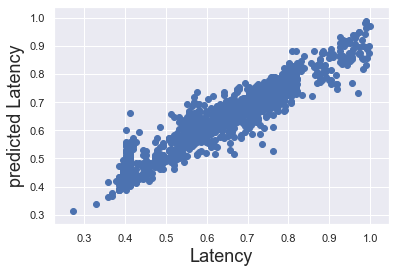

In [408]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

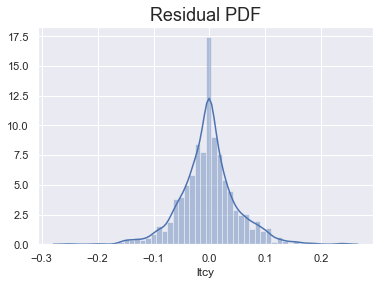

In [409]:
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

# Testing

In [410]:
y_hat_test = search.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

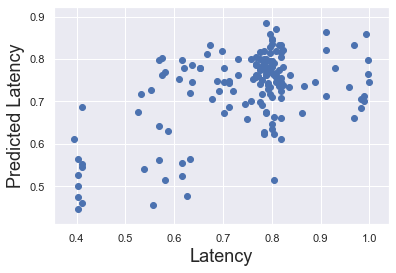

In [411]:
plt.scatter(y_test, y_hat_test)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

In [412]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

,prediction,target
0,2.160,1.788
1,2.089,2.256
2,1.960,2.018
3,2.179,2.018
4,2.081,2.219


In [413]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,2.160,1.788,0.372,20.799
1,2.089,2.256,-0.168,7.437
2,1.960,2.018,-0.059,2.915
3,2.179,2.018,0.161,7.959
4,2.081,2.219,-0.138,6.202
...,...,...,...,...
154,2.065,1.999,0.066,3.303
155,2.048,2.181,-0.133,6.082
156,2.118,2.181,-0.063,2.902
157,2.228,2.134,0.094,4.428


In [414]:
perf.describe()

,prediction,target,residual,difference%
count,159.000,159.000,159.000,159.000
mean,2.083,2.130,-0.048,8.514
std,0.183,0.272,0.240,7.368
min,1.564,1.483,-0.701,0.015
25%,2.007,2.004,-0.168,2.568
50%,2.124,2.200,-0.022,6.202
75%,2.209,2.247,0.080,13.471
max,2.425,2.718,0.479,31.746


In [415]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
68,2.27,2.27,-0.00,0.02
46,2.22,2.22,-0.00,0.05
55,2.27,2.28,-0.00,0.06
102,1.72,1.71,0.00,0.08
73,2.26,2.27,-0.00,0.11
21,2.17,2.17,-0.00,0.12
27,2.19,2.18,0.01,0.30
135,2.06,2.06,0.01,0.31
29,2.17,2.18,-0.01,0.39
52,2.18,2.17,0.01,0.40


# Prediction Accuracy

In [416]:
r2_test = metrics.r2_score(y_test, y_hat_test)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

R2 (testing) = 0.25904997735965696
